In [248]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy import stats
#from helpers import *
pd.options.display.max_rows = 4000

%matplotlib inline
plt.style.use('ggplot')

## Reading in Dam and 303d data

In [4]:
impaired_waters_df = pd.read_csv('303d_impaired_waters_csv.csv')
cal_dams = pd.read_csv('ca_dams.csv')

In [369]:
# def plot_bar(x, y, title, size):
#     fig, ax = plt.subplots(figsize=size)

#     ax.set_title(title)
#     x_pos = [i for i, _ in enumerate(x)]
    
#     plt.xlabel("Water Body Type")
#     plt.ylabel("Number of Entries")
#     plt.title("Counts of Water Body Types in 303(d) Data")
#     plt.xticks(x_pos, x)
#     plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
#     plt.bar(x, y)
#     return ax

<AxesSubplot:title={'center':'Counts of Water Body Types in 303(d) Data'}, xlabel='Water Body Type', ylabel='Number of Entries'>

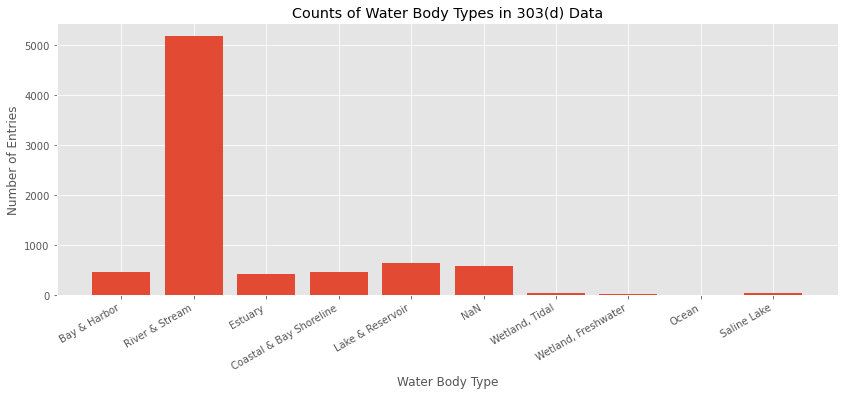

In [370]:
plot_water_bodies(body_list, amount_list, 'Number of Water Body Types', (14, 5))

## Exploratory data: Bar graph of all waterbodies and counts

In [252]:
body_dict = {}
impaired_waters_df['WATER BODY TYPE'] = impaired_waters_df['WATER BODY TYPE'].fillna('Null')

for body in impaired_waters_df['WATER BODY TYPE']:
    if body in body_dict:
        body_dict[body] += 1
    else:
        body_dict[body] = 1

body_list = []
amount_list = []
for k, v in body_dict.items():
    body_list.append(k)
    amount_list.append(int(v))
    
print(body_list, amount_list)



['Bay & Harbor', 'River & Stream', 'Estuary', 'Coastal & Bay Shoreline', 'Lake & Reservoir', 'NaN', 'Wetland, Tidal', 'Wetland, Freshwater', 'Ocean', 'Saline Lake'] [470, 5176, 426, 470, 644, 590, 33, 16, 1, 36]


## Clean up dfs a little

Cleaning up 303d data

In [5]:
##csv was from pdf and very messy - drop all rows with NA under Region column
impaired_waters_df=impaired_waters_df.dropna(axis=0, how='all')

##I'm only interested in analyzing river and stream impact - let's filter out all waterbodies that aren't rivers
##or streams
impaired_rivers = impaired_waters_df.loc[impaired_waters_df['WATER BODY TYPE'] == 'River & Stream']
#impaired_rivers.count()

In [6]:
impaired_rivers = impaired_rivers[['Region', 'Water Body Name', 
                                   'UNIT', 'POLLUTANT', 
                                   'POTENTIAL SOURCES', 
                                   'SOURCE CATEGORY']]
impaired_rivers.head()

,Region,Water Body Name,UNIT,POLLUTANT,POTENTIAL SOURCES,SOURCE CATEGORY
1,1,"Bodega HU, Estero Americano HA, Americano Creek",Miles,Nutrients,Dairies,Agriculture
2,1,"Bodega HU, Estero Americano HA, Americano Creek",Miles,Nutrients,Intensive Animal Feeding Operations,Agriculture
3,1,"Bodega HU, Estero Americano HA, Americano Creek",Miles,Nutrients,Manure Lagoons,Agriculture
4,1,"Bodega HU, Estero Americano HA, Americano Creek",Miles,Nutrients,Pasture Grazing-Riparian,Agriculture
5,1,"Bodega HU, Estero Americano HA, Americano Creek",Miles,Nutrients,Range Grazing-Riparian,Agriculture


Cleaning up dam data - dropping unnecessary columns


In [7]:
cal_dams.head()

,RECORDID,DAM_NAME,STATEID,NIDID,LONGITUDE,LATITUDE,SECTION,COUNTY,RIVER,CITY,...,CONG_NAME,PARTY,CONG_DIST,OTHERSTRUCTUREID,NUMSEPARATESTRUCTURES,PERMITTINGAUTHORITY,INSPECTIONAUTHORITY,ENFORCEMENTAUTHORITY,JURISDICTIONALDAM,EAP_LAST_REV_DATE
0,4011,Mendocino Middle,NaN,CA00001,-123.1355,39.1310,NaN,MENDOCINO,MIDDLE CREEK,2,...,Jared Huffman (D),D,CA02,NaN,0.0,Y,Y,Y,Y,NaN
1,4012,Mendocino 3 Upper,NaN,CA00002,-123.1302,39.1274,NaN,MENDOCINO,MIDDLE CREEK,2.3,...,Jared Huffman (D),D,CA02,NaN,0.0,Y,Y,Y,Y,NaN
2,4013,"CAMILLE, LAKE",NaN,CA00003,-122.2525,38.2775,NaN,NAPA,TR TULUCAY CR,1,...,Mike Thompson (D),D,CA05,NaN,0.0,Y,Y,Y,Y,12-DEC-15
3,4014,"MARIE, LAKE",NaN,CA00004,-122.2293,38.2598,NaN,NAPA,TR TULUCAY CR,2.4,...,Mike Thompson (D),D,CA05,NaN,0.0,Y,Y,Y,Y,12-DEC-15
4,4015,HENDERSON,NaN,CA00005,-120.8771,38.3856,NaN,AMADOR,JACKASS CREEK,4.5,...,Tom McClintock (R),R,CA04,NaN,0.0,Y,Y,Y,Y,NaN


In [8]:
## group dam attributes into one list
cal_dams['ATTRIBUTES'] = cal_dams.apply(lambda x: list([x['YEAR_COMPLETED'], 
                                                        x['DAM_LENGTH'], 
                                                        x['DAM_HEIGHT'], 
                                                        x['MAX_DISCHARGE'], 
                                                        x['MAX_STORAGE'],
                                                        x['NORMAL_STORAGE'],
                                                        x['SURFACE_AREA'],
                                                        x['DRAINAGE_AREA']
                                                       ]),axis=1)

# merge_columns(cal_dams, 'ATTRIBUTES', ['YEAR_COMPLETED', 
#                                        'DAM_LENGTH', 
#                                        'DAM_HEIGHT', 
#                                        'MAX_DISCHARGE', 
#                                        'MAX_STORAGE', 
#                                        'NORMAL_STORAGE', 
#                                        'SURFACE_AREA', 
#                                        'DRAINAGE_AREA']])


In [9]:
## reduce dataframe

cal_dams = cal_dams[['DAM_NAME', 'RIVER', 'VOLUME', 'PRIVATE_DAM', 'ATTRIBUTES']]
cal_dams.head()

,DAM_NAME,RIVER,VOLUME,PRIVATE_DAM,ATTRIBUTES
0,Mendocino Middle,MIDDLE CREEK,0.0,N,"[1908.0, 119.0, 39.0, 0.0, 0.0, 27.0, 2.0, 3.75]"
1,Mendocino 3 Upper,MIDDLE CREEK,0.0,N,"[1915.0, 254.0, 49.0, 0.0, 0.0, 85.0, 5.0, 3.2]"
2,"CAMILLE, LAKE",TR TULUCAY CR,22000.0,N,"[1880.0, 600.0, 30.0, 0.0, 0.0, 47.0, 3.0, 0.1]"
3,"MARIE, LAKE",TR TULUCAY CR,75000.0,N,"[1908.0, 454.0, 60.0, 0.0, 0.0, 170.0, 8.0, 1.06]"
4,HENDERSON,JACKASS CREEK,70000.0,N,"[1923.0, 630.0, 56.0, 0.0, 0.0, 500.0, 31.0, 1.0]"


## Dealing with NANs in crucial places
There are 90 dams that don't have data for River. We will drop these and maybe manually input data later

In [10]:
#df = df[df['EPS'].notna()]
no_river = cal_dams[cal_dams['RIVER'].isna()]
no_river.head()

,DAM_NAME,RIVER,VOLUME,PRIVATE_DAM,ATTRIBUTES
69,UPPER FRANKLIN DAM,NaN,0.0,N,"[1915.0, 260.0, 40.0, 192.0, 150.0, 0.0, 0.0, ..."
129,MORRIS S. JONES,NaN,68000.0,N,"[1952.0, 1470.0, 49.0, 0.0, 0.0, 153.3, 6.3, 0.0]"
462,JANES FLAT,NaN,9180.0,N,"[1918.0, 785.0, 22.0, 780.0, 0.0, 0.0, 0.0, 0.0]"
717,HALL MILL DAM,NaN,0.0,N,"[1949.0, 220.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1108,TAHQUITZ,NaN,0.0,N,"[nan, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [11]:
cal_dams['RIVER'] = cal_dams['RIVER'].str.lower()
impaired_rivers['Water Body Name'] = impaired_rivers['Water Body Name'].str.lower()

cal_dams = cal_dams[cal_dams['RIVER'].notna()]
cal_dams = cal_dams.loc[cal_dams['RIVER'] != 'offstream']
cal_dams = cal_dams.loc[cal_dams['RIVER'] != 'y']
cal_dams = cal_dams.loc[cal_dams['RIVER'] != '.']
cal_dams = cal_dams.loc[cal_dams['RIVER'] != 3]


#impaired_rivers = impaired_waters_df.loc[impaired_waters_df['WATER BODY TYPE'] == 'River & Stream
cal_dams.count()

DAM_NAME       1395
RIVER          1396
VOLUME         1394
PRIVATE_DAM    1396
ATTRIBUTES     1396
dtype: int64

We want Strings in: Water Body Name, WATER BODY TYPE, POLLUTANT:FINAL LISTING DECISION
Ints in: Region, WBID

## What types of data are in our dams and impaired rivers datasets?

In [12]:
cal_dams.dtypes

DAM_NAME        object
RIVER           object
VOLUME         float64
PRIVATE_DAM     object
ATTRIBUTES      object
dtype: object

In [13]:
def to_numeric(df, cols):
    for col in cols:
        df[col] = df[col].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [14]:
to_numeric(impaired_rivers, ['Region'])
impaired_rivers.head()

,Region,Water Body Name,UNIT,POLLUTANT,POTENTIAL SOURCES,SOURCE CATEGORY
1,1,"bodega hu, estero americano ha, americano creek",Miles,Nutrients,Dairies,Agriculture
2,1,"bodega hu, estero americano ha, americano creek",Miles,Nutrients,Intensive Animal Feeding Operations,Agriculture
3,1,"bodega hu, estero americano ha, americano creek",Miles,Nutrients,Manure Lagoons,Agriculture
4,1,"bodega hu, estero americano ha, americano creek",Miles,Nutrients,Pasture Grazing-Riparian,Agriculture
5,1,"bodega hu, estero americano ha, americano creek",Miles,Nutrients,Range Grazing-Riparian,Agriculture


## Now we'll group the like-rivers together and append all their polutant and possible sources together. 

In [15]:
impaired_rivers['all_potential_sources'] = impaired_rivers[[
    'Water Body Name',
    'POTENTIAL SOURCES']].groupby('Water Body Name')['POTENTIAL SOURCES'].transform(lambda x: ', '.join(x))


# impaired_rivers['All Pollutant Categories'] = impaired_rivers[[
#     'Water Body Name',
#     'POLLUTANT CATEGORY']].groupby('Water Body Name')['POLLUTANT CATEGORY'].transform(lambda x: ', '.join(x))

impaired_rivers['All Pollutants'] = impaired_rivers[[
    'Water Body Name',
    'POLLUTANT']].groupby('Water Body Name')['POLLUTANT'].transform(lambda x: ', '.join(x))

#all individual rivers
impaired = impaired_rivers[['Water Body Name', 'All Pollutants', 'Region',
                 'all_potential_sources']].drop_duplicates()
impaired.head()

,Water Body Name,All Pollutants,Region,all_potential_sources
1,"bodega hu, estero americano ha, americano creek","Nutrients, Nutrients, Nutrients, Nutrients, Nu...",1,"Dairies, Intensive Animal Feeding Operations, ..."
15,"bodega hu, estero de san antonio ha, stemple c...","Nutrients, Sediment, Sediment, Sediment, Sedim...",1,"Source Unknown, Agriculture, Erosion/Siltation..."
27,"cape mendocino hu, mattole river ha, mattole r...","Sedimentation/Siltation, Sedimentation/Siltati...",1,"Erosion/Siltation, Habitat Modification, Hydro..."
55,"eel river hu, lower eel river ha (includes the...","Aluminum, Oxygen, Dissolved, Sedimentation/Sil...",1,"Natural Sources, Source Unknown, Erosion/Silta..."
63,"eel river hu, middle fork ha, eden valley and ...","Aluminum, Sedimentation/Siltation, Temperature...",1,"Natural Sources, Erosion/Siltation, Nonpoint S..."


In [16]:
impaired.head()

,Water Body Name,All Pollutants,Region,all_potential_sources
1,"bodega hu, estero americano ha, americano creek","Nutrients, Nutrients, Nutrients, Nutrients, Nu...",1,"Dairies, Intensive Animal Feeding Operations, ..."
15,"bodega hu, estero de san antonio ha, stemple c...","Nutrients, Sediment, Sediment, Sediment, Sedim...",1,"Source Unknown, Agriculture, Erosion/Siltation..."
27,"cape mendocino hu, mattole river ha, mattole r...","Sedimentation/Siltation, Sedimentation/Siltati...",1,"Erosion/Siltation, Habitat Modification, Hydro..."
55,"eel river hu, lower eel river ha (includes the...","Aluminum, Oxygen, Dissolved, Sedimentation/Sil...",1,"Natural Sources, Source Unknown, Erosion/Silta..."
63,"eel river hu, middle fork ha, eden valley and ...","Aluminum, Sedimentation/Siltation, Temperature...",1,"Natural Sources, Erosion/Siltation, Nonpoint S..."


## Now we can make another dataframe with all the impaired rivers with 'dam' listed as possible source. We will combine this dataframe with our final dammed_and_impaired dataframe if there are missing values

In [17]:
impaired_rivers_with_dam = impaired[impaired['all_potential_sources'].str.contains("Dam")]
impaired_rivers_with_dam.count()
#df[df['A'].str.contains("hello")]

Water Body Name          15
All Pollutants           15
Region                   15
all_potential_sources    15
dtype: int64

In [18]:
impaired_rivers_with_dam.head(40)

,Water Body Name,All Pollutants,Region,all_potential_sources
231,"klamath river hu, lower ha, klamath glen hsa","Nutrients, Nutrients, Nutrients, Nutrients, Nu...",1,"Agriculture, Agriculture-irrigation tailwater,..."
273,"klamath river hu, middle ha and lower ha, scot...","Cyanobacteria hepatotoxic microcystins, Cyanob...",1,"Agricultural Water Diversion, Agriculture, Dam..."
336,"klamath river hu, middle ha, iron gate dam to ...","Cyanobacteria hepatotoxic microcystins, Cyanob...",1,"Agriculture, Dam Construction, Drainage/Fillin..."
371,"klamath river hu, middle ha, oregon to iron gate","Cyanobacteria hepatotoxic microcystins, Cyanob...",1,"Agriculture, Dam Construction, Drainage/Fillin..."
437,"klamath river hu, shasta river ha","Organic Enrichment/Low Dissolved Oxygen, Organ...",1,"Agriculture-irrigation tailwater, Agriculture-..."
586,"russian river hu, lower russian river ha, aust...","Sedimentation/Siltation, Sedimentation/Siltati...",1,"Construction/Land Development, Dam Constructio..."
602,"russian river hu, lower russian river ha, guer...","Indicator Bacteria, Sedimentation/Siltation, S...",1,"Source Unknown, Agriculture, Agriculture-grazi..."
811,"russian river hu, upper russian river ha, coyo...","Sedimentation/Siltation, Sedimentation/Siltati...",1,"Agriculture, Bridge Construction, Channel Eros..."
881,"trinity river hu, lower trinity ha","Sedimentation/Siltation, Sedimentation/Siltati...",1,"Channel Erosion, Dam Construction, Drainage/Fi..."
904,"trinity river hu, middle ha","Sedimentation/Siltation, Sedimentation/Siltati...",1,"Channel Erosion, Dam Construction, Erosion/Sil..."


## Now for the tricky part... We need to match up dammed rivers with impaired rivers

Our goal is to compile a dataframe with columns:

'River', 'Dam attributes', 'All Pollutants', 'All potential Sources'


In [19]:
cal_dams.head()

,DAM_NAME,RIVER,VOLUME,PRIVATE_DAM,ATTRIBUTES
0,Mendocino Middle,middle creek,0.0,N,"[1908.0, 119.0, 39.0, 0.0, 0.0, 27.0, 2.0, 3.75]"
1,Mendocino 3 Upper,middle creek,0.0,N,"[1915.0, 254.0, 49.0, 0.0, 0.0, 85.0, 5.0, 3.2]"
2,"CAMILLE, LAKE",tr tulucay cr,22000.0,N,"[1880.0, 600.0, 30.0, 0.0, 0.0, 47.0, 3.0, 0.1]"
3,"MARIE, LAKE",tr tulucay cr,75000.0,N,"[1908.0, 454.0, 60.0, 0.0, 0.0, 170.0, 8.0, 1.06]"
4,HENDERSON,jackass creek,70000.0,N,"[1923.0, 630.0, 56.0, 0.0, 0.0, 500.0, 31.0, 1.0]"


In [20]:
impaired = impaired.set_index('Water Body Name', drop=False)
impaired = impaired.rename(columns={'Water Body Name': 'Merger'})

cal_dams = cal_dams.set_index('RIVER', drop=False)
cal_dams = cal_dams.rename(columns={'RIVER': 'Merger'})

impaired.head()

,Merger,All Pollutants,Region,all_potential_sources
Water Body Name,,,,
"bodega hu, estero americano ha, americano creek","bodega hu, estero americano ha, americano creek","Nutrients, Nutrients, Nutrients, Nutrients, Nu...",1,"Dairies, Intensive Animal Feeding Operations, ..."
"bodega hu, estero de san antonio ha, stemple creek/estero de san antonio","bodega hu, estero de san antonio ha, stemple c...","Nutrients, Sediment, Sediment, Sediment, Sedim...",1,"Source Unknown, Agriculture, Erosion/Siltation..."
"cape mendocino hu, mattole river ha, mattole river","cape mendocino hu, mattole river ha, mattole r...","Sedimentation/Siltation, Sedimentation/Siltati...",1,"Erosion/Siltation, Habitat Modification, Hydro..."
"eel river hu, lower eel river ha (includes the eel river delta)","eel river hu, lower eel river ha (includes the...","Aluminum, Oxygen, Dissolved, Sedimentation/Sil...",1,"Natural Sources, Source Unknown, Erosion/Silta..."
"eel river hu, middle fork ha, eden valley and round valley hsas","eel river hu, middle fork ha, eden valley and ...","Aluminum, Sedimentation/Siltation, Temperature...",1,"Natural Sources, Erosion/Siltation, Nonpoint S..."


In [21]:
cal_dams.head()

,DAM_NAME,Merger,VOLUME,PRIVATE_DAM,ATTRIBUTES
RIVER,,,,,
middle creek,Mendocino Middle,middle creek,0.0,N,"[1908.0, 119.0, 39.0, 0.0, 0.0, 27.0, 2.0, 3.75]"
middle creek,Mendocino 3 Upper,middle creek,0.0,N,"[1915.0, 254.0, 49.0, 0.0, 0.0, 85.0, 5.0, 3.2]"
tr tulucay cr,"CAMILLE, LAKE",tr tulucay cr,22000.0,N,"[1880.0, 600.0, 30.0, 0.0, 0.0, 47.0, 3.0, 0.1]"
tr tulucay cr,"MARIE, LAKE",tr tulucay cr,75000.0,N,"[1908.0, 454.0, 60.0, 0.0, 0.0, 170.0, 8.0, 1.06]"
jackass creek,HENDERSON,jackass creek,70000.0,N,"[1923.0, 630.0, 56.0, 0.0, 0.0, 500.0, 31.0, 1.0]"


In [22]:
for impaired_river in impaired['Merger']:
    
    for river in cal_dams['Merger']:
        if river in impaired_river:
            impaired['Merger'].loc[impaired['Merger'] == impaired_river] = river
            impaired_river = river
            break

            

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [23]:
impaired.head(20)
#impaired = impaired.drop(labels=['Dam','Merge'], axis=1)
#print(type(impaired['Water Body Name'][3]))
impaired.head()

,Merger,All Pollutants,Region,all_potential_sources
Water Body Name,,,,
"bodega hu, estero americano ha, americano creek","bodega hu, estero americano ha, americano creek","Nutrients, Nutrients, Nutrients, Nutrients, Nu...",1,"Dairies, Intensive Animal Feeding Operations, ..."
"bodega hu, estero de san antonio ha, stemple creek/estero de san antonio","bodega hu, estero de san antonio ha, stemple c...","Nutrients, Sediment, Sediment, Sediment, Sedim...",1,"Source Unknown, Agriculture, Erosion/Siltation..."
"cape mendocino hu, mattole river ha, mattole river","cape mendocino hu, mattole river ha, mattole r...","Sedimentation/Siltation, Sedimentation/Siltati...",1,"Erosion/Siltation, Habitat Modification, Hydro..."
"eel river hu, lower eel river ha (includes the eel river delta)",eel river,"Aluminum, Oxygen, Dissolved, Sedimentation/Sil...",1,"Natural Sources, Source Unknown, Erosion/Silta..."
"eel river hu, middle fork ha, eden valley and round valley hsas",eel river,"Aluminum, Sedimentation/Siltation, Temperature...",1,"Natural Sources, Erosion/Siltation, Nonpoint S..."


In [24]:
## Condense cal_dams to only one entry per river

s_cal_dams = cal_dams.groupby(['Merger'], sort=False)['PRIVATE_DAM'].apply(lambda x: ','.join(x.astype(str)))
s_cal_dams.head()

Merger
middle creek           N,N
tr tulucay cr          N,N
jackass creek          N,N
tr mill creek            N
tr napa river    N,N,N,N,N
Name: PRIVATE_DAM, dtype: object

In [25]:
cal_dams[cal_dams['Merger'].str.contains("offstream")]

,DAM_NAME,Merger,VOLUME,PRIVATE_DAM,ATTRIBUTES
RIVER,,,,,
pit river - offstream,Collett Addition,pit river - offstream,0.0,N,"[1991.0, 2900.0, 40.0, 700.0, 7690.0, 0.0, 255..."
santa margarita riv offstream,LAKE O'NEILL DAM,santa margarita riv offstream,0.0,N,"[1883.0, 1500.0, 14.0, 800.0, 1395.0, 1057.0, ..."
senator wash - offstream,SENATOR WASH NORTH DIKE,senator wash - offstream,79000.0,N,"[1966.0, 613.0, 64.2, 0.0, 17766.0, 9144.0, 51..."
senator wash - offstream,SENATOR WASH SQUAW LAKE DIKE,senator wash - offstream,950000.0,N,"[1966.0, 3795.0, 95.3, 0.0, 17766.0, 9144.0, 5..."


# Merging impaired and cal_dams to one df
df = all impaired rivers with associated dam values

In [26]:
df = impaired.merge(s_cal_dams, how='left', left_on='Merger', right_on='Merger')

In [27]:
# df[df['PRIVATE_DAM'] == 'Y'].count()

In [28]:
#impaired.head(30)
print(df['All Pollutants'][3])

df.head()


Aluminum, Oxygen, Dissolved, Sedimentation/Siltation, Sedimentation/Siltation, Sedimentation/Siltation, Sedimentation/Siltation, Temperature, water, Temperature, water


,Merger,All Pollutants,Region,all_potential_sources,PRIVATE_DAM
0,"bodega hu, estero americano ha, americano creek","Nutrients, Nutrients, Nutrients, Nutrients, Nu...",1,"Dairies, Intensive Animal Feeding Operations, ...",NaN
1,"bodega hu, estero de san antonio ha, stemple c...","Nutrients, Sediment, Sediment, Sediment, Sedim...",1,"Source Unknown, Agriculture, Erosion/Siltation...",NaN
2,"cape mendocino hu, mattole river ha, mattole r...","Sedimentation/Siltation, Sedimentation/Siltati...",1,"Erosion/Siltation, Habitat Modification, Hydro...",NaN
3,eel river,"Aluminum, Oxygen, Dissolved, Sedimentation/Sil...",1,"Natural Sources, Source Unknown, Erosion/Silta...","N,N"
4,eel river,"Aluminum, Sedimentation/Siltation, Temperature...",1,"Natural Sources, Erosion/Siltation, Nonpoint S...","N,N"


# Still need to remove duplicates from 'All Pollutants', 'All_potential_sources'

In [29]:
df['Num Pollutants'] = 0
for i in range (df['All Pollutants'].count()):
    p_list = df['All Pollutants'][i].split(', ')
    p_list = list(dict.fromkeys(p_list))
#    df['All Pollutants'][i] = ', '.join(p_list)
    df['All Pollutants'][i] = p_list

    df['Num Pollutants'][i] = len(p_list)
    
df.head()

<ipython-input-29-2403ac1f45e9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['All Pollutants'][i] = p_list
<ipython-input-29-2403ac1f45e9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Num Pollutants'][i] = len(p_list)


,Merger,All Pollutants,Region,all_potential_sources,PRIVATE_DAM,Num Pollutants
0,"bodega hu, estero americano ha, americano creek",[Nutrients],1,"Dairies, Intensive Animal Feeding Operations, ...",NaN,1
1,"bodega hu, estero de san antonio ha, stemple c...","[Nutrients, Sediment]",1,"Source Unknown, Agriculture, Erosion/Siltation...",NaN,2
2,"cape mendocino hu, mattole river ha, mattole r...","[Sedimentation/Siltation, Temperature, water]",1,"Erosion/Siltation, Habitat Modification, Hydro...",NaN,3
3,eel river,"[Aluminum, Oxygen, Dissolved, Sedimentation/Si...",1,"Natural Sources, Source Unknown, Erosion/Silta...","N,N",6
4,eel river,"[Aluminum, Sedimentation/Siltation, Temperatur...",1,"Natural Sources, Erosion/Siltation, Nonpoint S...","N,N",4


In [30]:
df.count()

Merger                   704
All Pollutants           704
Region                   704
all_potential_sources    704
PRIVATE_DAM              334
Num Pollutants           704
dtype: int64

In [31]:
type(df['All Pollutants'].count())

numpy.int64

In [32]:
df.head()

,Merger,All Pollutants,Region,all_potential_sources,PRIVATE_DAM,Num Pollutants
0,"bodega hu, estero americano ha, americano creek",[Nutrients],1,"Dairies, Intensive Animal Feeding Operations, ...",NaN,1
1,"bodega hu, estero de san antonio ha, stemple c...","[Nutrients, Sediment]",1,"Source Unknown, Agriculture, Erosion/Siltation...",NaN,2
2,"cape mendocino hu, mattole river ha, mattole r...","[Sedimentation/Siltation, Temperature, water]",1,"Erosion/Siltation, Habitat Modification, Hydro...",NaN,3
3,eel river,"[Aluminum, Oxygen, Dissolved, Sedimentation/Si...",1,"Natural Sources, Source Unknown, Erosion/Silta...","N,N",6
4,eel river,"[Aluminum, Sedimentation/Siltation, Temperatur...",1,"Natural Sources, Erosion/Siltation, Nonpoint S...","N,N",4


# PLOTTING TIME



## Final Steps Before Analysis:

1. We need to input dam data to impaired df when we are iterating through


## Bar Chart of #dammed vs. #undammed

In [331]:
df_dammed = df[df['PRIVATE_DAM'].notnull()]
df_not_dammed = df.loc[df['PRIVATE_DAM'].isnull()]
type(df_dammed)

pandas.core.frame.DataFrame

Text(0.5, 1.0, 'Pergentage of Dammed and Undammed Impaired Rivers')

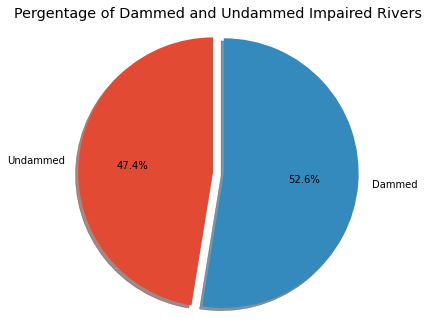

In [341]:
num = [len(df_dammed), len(df_not_dammed)]
labels = ['Undammed', 'Dammed']
explode = (0, 0.08)

fig1, ax1 = plt.subplots(figsize=(5.5,5.5))
ax1.pie(num, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Pergentage of Dammed and Undammed Impaired Rivers')

Let's make a histogram for # of pollutants in dammed and undammed rivers:

array([<AxesSubplot:title={'center':'Num Pollutants'}>], dtype=object)

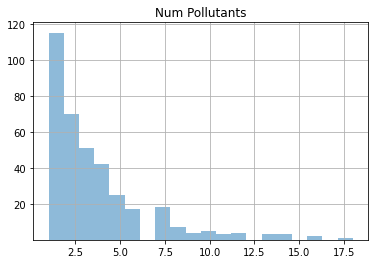

In [130]:
df_dammed.index = np.arange(0, len(df_dammed))
df_not_dammed.index = np.arange(0, len(df_not_dammed))

fig, ax = plt.subplots()
#df_dammed.hist('Num Pollutants', ax=ax, bins=20, bottom=0.1, alpha=.5, color='black')
df_not_dammed.hist('Num Pollutants', ax=ax, bins=20, bottom=0.1, alpha=.5)

array([<AxesSubplot:title={'center':'Num Pollutants'}>], dtype=object)

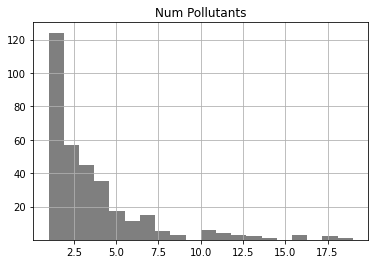

In [134]:
fig, ax = plt.subplots()
df_dammed.hist('Num Pollutants',ax=ax, bins=20, bottom=0.1, alpha=.5, color='black')

Now we should plot individual pollutants on the x-axis, and a stacked bar chart on top!

1: make a list(maybe dictionary?) of all pollutants

2: 

A/B Test: Dammed Rivers have more pollutants than non-dammed rivers:
ho: Dammed rivers and un_dammed rivers have the same average number of pollutants
ha: dammed rivers have more pollutants than undammed rivers



In [132]:
A/B Test:
    ho: dammed rivers and undammed rivers have the same distribution of impairments
    ha: they have a different distribution of impairments

SyntaxError: invalid syntax (<ipython-input-132-32d63199a870>, line 1)

334

In [54]:
#df_dammed:
n = df_dammed['Num Pollutants'].count()   
p = sum([x for x in df_dammed['Num Pollutants']])/n
p
#binomial = stats.binom(n=3100, p=0.80)

3.3502994011976046

In [55]:
def bootstrap_sample_means(data, n_bootstrap_samples=10000):
    bootstrap_sample_means = []
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=300, replace=True)  ##changed from size=len(data)
        bootstrap_sample_means.append(np.mean(bootstrap_sample))
    return bootstrap_sample_means

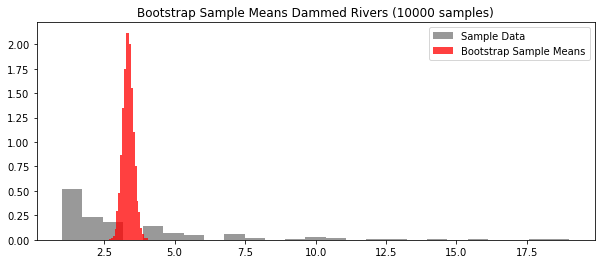

In [56]:
dammed_means = bootstrap_sample_means(df_dammed['Num Pollutants'])


fig, ax = plt.subplots(1, figsize=(10, 4))
_ = ax.hist(df_dammed['Num Pollutants'], bins=25, density=True, color="black", alpha=0.4,
            label="Sample Data")
_ = ax.hist(dammed_means, bins=25, density=True, color="red", alpha=0.75,
            label="Bootstrap Sample Means")
ax.legend()
_ = ax.set_title("Bootstrap Sample Means Dammed Rivers (10000 samples)")

# Need to normalize based on sample size!

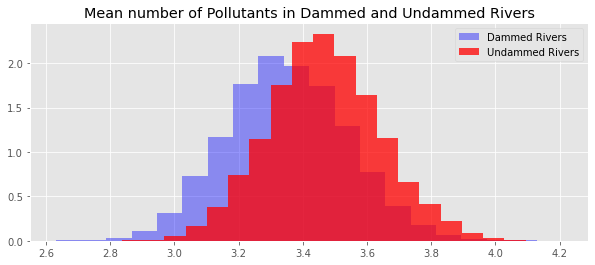

In [342]:
## dammed means vs undammed means

dammed_means = bootstrap_sample_means(df_dammed['Num Pollutants'])
undammed_means = bootstrap_sample_means(df_not_dammed['Num Pollutants'])


fig, ax = plt.subplots(1, figsize=(10, 4))
_ = ax.hist(dammed_means, bins=20, density=True, color="blue", alpha=0.4,
            label="Dammed Rivers")
_ = ax.hist(undammed_means, bins=20, density=True, color="red", alpha=0.75,
            label="Undammed Rivers")
ax.legend()
_ = ax.set_title("Mean number of Pollutants in Dammed and Undammed Rivers")

# Plot stacked bar graph

In [ ]:
n = 19
# 




In [ ]:
keys = dammed_most_potent.keys()
values = dammed_most_potent.values()

fig, ax = plt.subplots(figsize=(16,5))
plt.bar(keys, values)



N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, yerr=menStd)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans, yerr=womenStd)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

In [46]:
df_dammed.head()

,Merger,All Pollutants,Region,all_potential_sources,PRIVATE_DAM,Num Pollutants
3,eel river,"[Aluminum, Oxygen, Dissolved, Sedimentation/Si...",1,"Natural Sources, Source Unknown, Erosion/Silta...","N,N",6
4,eel river,"[Aluminum, Sedimentation/Siltation, Temperatur...",1,"Natural Sources, Erosion/Siltation, Nonpoint S...","N,N",4
5,eel river,"[Temperature, water]",1,"Nonpoint Source, Removal of Riparian Vegetation","N,N",2
6,eel river,"[Aluminum, Sedimentation/Siltation, Temperatur...",1,"Natural Sources, Construction/Land Development...","N,N",4
7,eel river,"[Sedimentation/Siltation, Temperature, water]",1,"Erosion/Siltation, Logging Road Construction/M...","N,N",3


In [314]:
dammed_pollutant_dict = {}
for pol in df_dammed['All Pollutants']:
    for pollutant in pol:
        if pollutant in dammed_pollutant_dict:
            dammed_pollutant_dict[pollutant] += 1
        else:
            dammed_pollutant_dict[pollutant] = 1
#for k, v in dammed_pollutant_dict.items():
#    print(k, v)
dammed_most_potent = {k:v for (k,v) in dammed_pollutant_dict.items() if v > 20}
len(dammed_most_potent)

15

In [283]:
df_dammed['All Pollutants'][3]
len(df_dammed)

334

In [284]:
undammed_pollutant_dict = {}
for pol in df_not_dammed['All Pollutants']:
    for pollutant in pol:
        if pollutant in undammed_pollutant_dict:
            undammed_pollutant_dict[pollutant] += 1
        else:
            undammed_pollutant_dict[pollutant] = 1

        
            

#twentyfive most potent
undammed_most_potent = {k:v for (k,v) in undammed_pollutant_dict.items() if v > 28}

len(undammed_most_potent)

# Agricultural = ['Diazinon', 'Pyrethroids', 'Nitrate', 
#                 'Chlorpyrifos', 'DDT (Dichlorodiphenyltrichloro ethane)',
#                'Dieldrin', 'Nitrogen', 'Total Nitrogen as N']
# Metals = ['Copper', 'Zinc', 'Lead', 'Iron']

15

In [285]:
print(undammed_pollutant_dict['Mercury'])
print(dammed_pollutant_dict['Mercury'], dammed_pollutant_dict['Unknown Toxicity'])

sum = 0
for k, v in undammed_pollutant_dict.items():
    sum += v
16/sum

16
55 55


0.012470771628994544

# Plot bars side by side

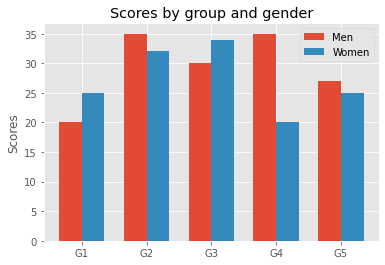

In [286]:
N = 5
men_means = (20, 35, 30, 35, 27)
women_means = (25, 32, 34, 20, 25)

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, men_means, width, label='Men')
plt.bar(ind + width, women_means, width,
    label='Women')

plt.ylabel('Scores')
plt.title('Scores by group and gender')

plt.xticks(ind + width / 2, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.legend(loc='best')
plt.show()

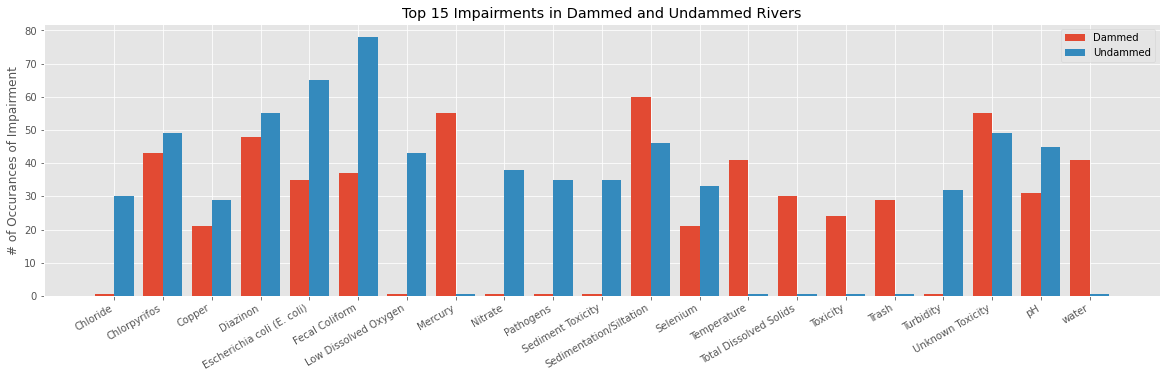

In [312]:
x_list = []
for k, v in dammed_most_potent.items():
    if k not in x_list:
        x_list.append(k)
    
for k, v in undammed_most_potent.items():
    if k not in x_list:
        x_list.append(k)
x_list = sorted(x_list)

dammed = []
for item in x_list:
    if item in dammed_most_potent:
        dammed.append(dammed_most_potent[item])
    else:
        dammed.append(0.5)
undammed = []
for item in x_list:
    if item in undammed_most_potent:
        undammed.append(undammed_most_potent[item])
    else:
        undammed.append(0.5)
        
fig, ax = plt.subplots(figsize=(20, 5))
        
N = len(x_list)
ind = np.arange(N)
width = 0.4
      
ax.bar(ind, dammed, width, label='Dammed')
ax.bar(ind + width , undammed, width,
      label='Undammed')

plt.ylabel('# of Occurances of Impairment')
plt.title('Top 15 Impairments in Dammed and Undammed Rivers')

plt.xticks(ind + width / 2, x_list)
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
plt.legend(loc='best')
plt.show()

<BarContainer object of 15 artists>

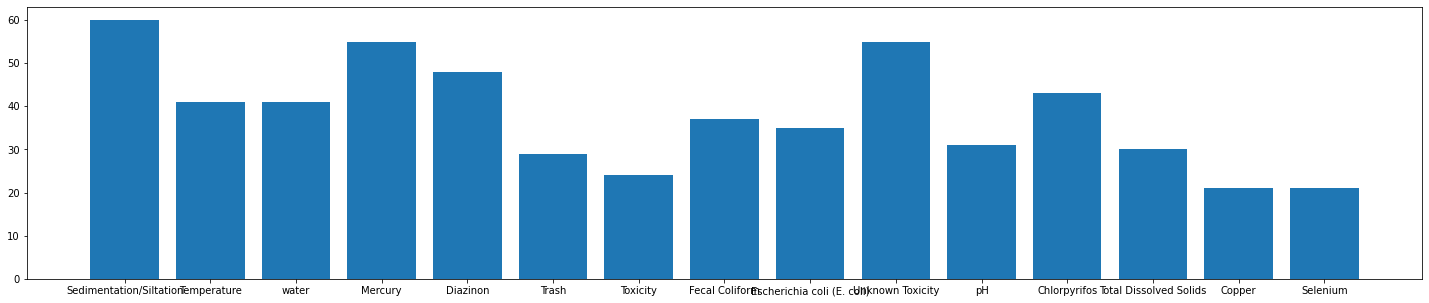

In [196]:
d_keys = dammed_most_potent.keys()
d_values = dammed_most_potent.values()

fig, ax = plt.subplots(figsize=(25,5))
plt.bar(keys, values)

<BarContainer object of 15 artists>

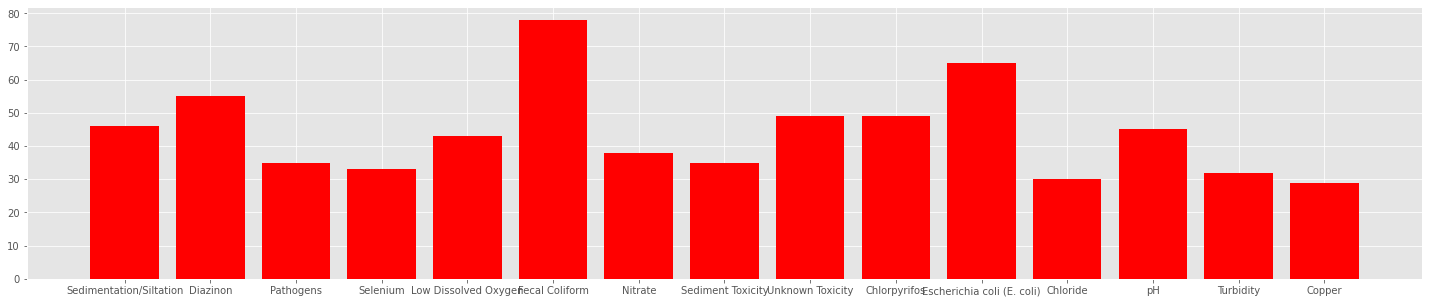

In [276]:
u_keys = undammed_most_potent.keys()
u_values = undammed_most_potent.values()

fig, ax = plt.subplots(figsize=(25,5))
plt.bar(u_keys, u_values, color='red')

## let's go through pollutants and classify them as 'direct human addition' or 'change of environmental condition'

In [198]:
sum=0
for k, v in undammed_most_potent.items():
    sum += v
    print(k, v)
print(sum)

Sedimentation/Siltation 46
Diazinon 55
Pathogens 35
Selenium 33
Low Dissolved Oxygen 43
Fecal Coliform 78
Nitrate 38
Sediment Toxicity 35
Unknown Toxicity 49
Chlorpyrifos 49
Escherichia coli (E. coli) 65
Chloride 30
pH 45
Turbidity 32
Copper 29
662


## Classifying top 15 pollutants as either 'Yes' or 'No' if they are TMDL solvable

In [199]:
he = {}
he['Diazinon'] = 'Yes'
he['Sedimentation/Siltation'] = 'No'
he['Pathogens'] = 'Yes'
he['Low Dissolved Oxygen'] = 'No'
he['Fecal Coliform'] = 'Yes'
he['Nitrate'] = 'Yes'
he['Sediment Toxicity'] = 'No'
he['Unknown Toxicity'] = 'No'
he['Chlorpyrifos'] = 'Yes'
he['Escherichia coli (E. coli)'] = 'Yes'
he['pH'] = 'No'
he['Chloride'] = 'Yes'
he['Turbidity'] = 'No'
he['Pathogens'] = 'No'
he['Selenium'] = 'Yes'
he['Temperature'] = 'No'
he['Mercury'] = 'No'
he['Copper'] = 'Yes'
he['Total Dissolved Solids'] = 'No'
he['Trash'] = 'Yes'
he['Toxicity'] = 'No'
he['water'] = 'No'


### Undammed %solvable

In [347]:
sum=0
undammed_solvable = 0
undammed_unsolvable = 0
for k, v in undammed_most_potent.items():
    if he[k] == 'Yes':
        undammed_solvable += v
    else:
        undammed_unsolvable += v
    sum += v
#    print(k, v)
print(sum)
print(undammed_solvable, undammed_unsolvable)

662
377 285


### Dammed %unsolvable

In [348]:
def solvability(most_potent_dict, he):
    sum=0
    solvable = 0
    unsolvable = 0
    for k, v in most_potent_dict.items():
        if he[k] == 'Yes':
            solvable += v
        else:
            unsolvable += v
        sum += v
    return [solvable, unsolvable]


### solvable vs. unsolvable pie chart

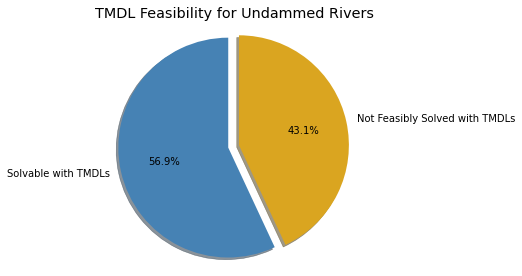

In [366]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Solvable with TMDLs', 'Not Feasibly Solved with TMDLs']
solvable = solvability(undammed_most_potent, he)
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(4.5, 4.5))
ax1.pie(solvable, explode=explode, labels=labels, colors=['steelblue', 'goldenrod'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('TMDL Feasibility for Undammed Rivers')
plt.show()

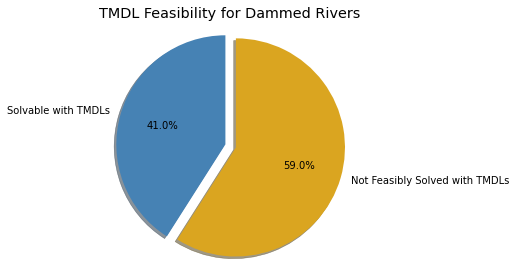

In [362]:
labels = ['Solvable with TMDLs', 'Not Feasibly Solved with TMDLs']
solvable = solvability(dammed_most_potent, he)
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(4.5,4.5))
ax1.pie(solvable, explode=explode, labels=labels, colors=['steelblue', 'goldenrod'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('TMDL Feasibility for Dammed Rivers')
plt.show()

In [150]:
sum_d=0
for k, v in dammed_most_potent.items():
    sum_d += v
    print(k, v)
print(sum_d)

Sedimentation/Siltation 60
Temperature 41
water 41
Mercury 55
Diazinon 48
Trash 29
Toxicity 24
Fecal Coliform 37
Escherichia coli (E. coli) 35
Unknown Toxicity 55
pH 31
Chlorpyrifos 43
Total Dissolved Solids 30
Copper 21
Selenium 21
571


In [143]:
he

{'Diazinon': 'Yes',
 'Sedimentation/Siltation': 'Location dependent',
 'Pathogens': 'No',
 'Low Dissolved Oxygen': 'No',
 'Fecal Coliform': 'Yes',
 'Nitrate': 'Yes',
 'Sediment Toxicity': 'No',
 'Unknown Toxicity': 'No',
 'Chlorpyrifos': 'Yes',
 'Escherichia coli': 'Yes',
 'pH': 'No',
 'Chloride': 'Yes',
 'Turbidity': 'No',
 'Selenium': 'Yes',
 'Temperature': 'No',
 'Mercury': 'No',
 'Copper': 'Yes',
 'Total Dissolved Solids': 'No',
 'Trash': 'Yes',
 'Toxicity': 'No'}

Run an A/B test to see whether there is a difference in the makeup of 'TMDL Treatable' vs. 'Environmental' for dammed and undammed!

Ho: Both undammed and dammed have same proportion of TMDL treatable to environmental impairements
Ha: dammed and undammed have a different proportion of TMDL to Environmental impairments



In [145]:
df_dammed.head()

,Merger,All Pollutants,Region,all_potential_sources,PRIVATE_DAM,Num Pollutants
0,eel river,"[Aluminum, Oxygen, Dissolved, Sedimentation/Si...",1,"Natural Sources, Source Unknown, Erosion/Silta...","N,N",6
1,eel river,"[Aluminum, Sedimentation/Siltation, Temperatur...",1,"Natural Sources, Erosion/Siltation, Nonpoint S...","N,N",4
2,eel river,"[Temperature, water]",1,"Nonpoint Source, Removal of Riparian Vegetation","N,N",2
3,eel river,"[Aluminum, Sedimentation/Siltation, Temperatur...",1,"Natural Sources, Construction/Land Development...","N,N",4
4,eel river,"[Sedimentation/Siltation, Temperature, water]",1,"Erosion/Siltation, Logging Road Construction/M...","N,N",3


In [148]:
df_not_dammed['Num Pollutants'].sum()

1283

In [149]:
df_dammed['Num Pollutants'].sum()

1119

In [152]:
df_not_dammed['Num Pollutants'].sum()

1283